## 知識情報学第7回演習サンプルプログラム ex7.ipynb
- Programmed by Ken-ichi Fukui
- Last updated: 2023/11/13
- Checked with Python 3.8.16, scikit-learn 1.3.2
- MIT License

## 多層パーセプトロンによる手書き文字認識

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.model_selection import ValidationCurveDisplay, validation_curve
from sklearn.pipeline import Pipeline

In [3]:
# openmlからMNISTデータをダウンロード
X_all, y_all = fetch_openml('mnist_784', return_X_y=True, parser='auto')

# 最初の2000点のみ使用する
n_sub_data = 2000
X_sub, y_sub = X_all[:n_sub_data], y_all[:n_sub_data]

### 課題1(a) PCAにより次元圧縮を行い，圧縮後の空間でMLPにより学習するように変更する．
- PCAによる次元圧縮は関数化すると良い
- MLP Classifier
    - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [4]:
def reduce_dimensions(X, n_components):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced

In [5]:
n_components = 50  # 削減後の次元数
X_sub_reduced = reduce_dimensions(X_sub, n_components)

mlp = MLPClassifier(
        hidden_layer_sizes=(100,), #隠れ層のノード数
        activation='relu',         #活性化関数
        solver='adam',             #最適化アルゴリズム
)
mlp.fit(X_sub_reduced, y_sub)
acc_trn = mlp.score(X_sub_reduced, y_sub)
print(acc_trn)

1.0


### 損失関数の学習曲線をプロット

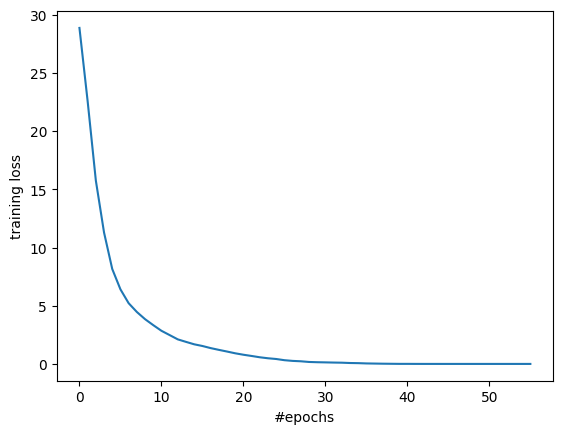

In [6]:
plt.plot(mlp.loss_curve_)
plt.xlabel("#epochs")
plt.ylabel("training loss")
plt.show()

### 課題1(b) 早期停止を設定し，検証データに対するAccuarcyの学習曲線をプロット
- 早期停止も過学習を抑制する方法のひとつ．検証データでAccuracyもしくはLossが一定期間停滞したら学習を停止する

0.9875


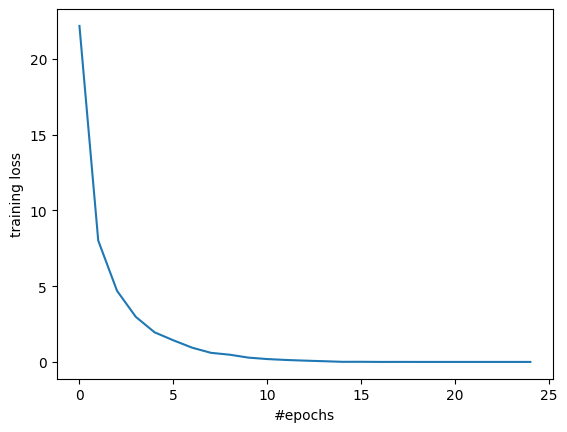

In [7]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100,), #隠れ層のノード数
    activation='relu',         #活性化関数
    solver='adam',             #最適化アルゴリズム
    early_stopping=True,
)

mlp.fit(X_sub, y_sub)
acc_trn = mlp.score(X_sub, y_sub)
print(acc_trn)
plt.plot(mlp.loss_curve_)

plt.xlabel("#epochs")
plt.ylabel("training loss")
plt.show()

### 課題2: 主成分数，隠れノード数，学習データ数の影響を考察
- あるパラメータを振る時は，その他のパラメータは固定で良い
- 評価方法についても各自で考えること
- ヒント：ValidationCurveDisplay, LearningCurveDisplayを使用すると隠れノード数，学習データ数に対する描画が簡単にできる
  - 使用しなくても良い
  - scikit-learn 1.3以上
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html

### 主成分数

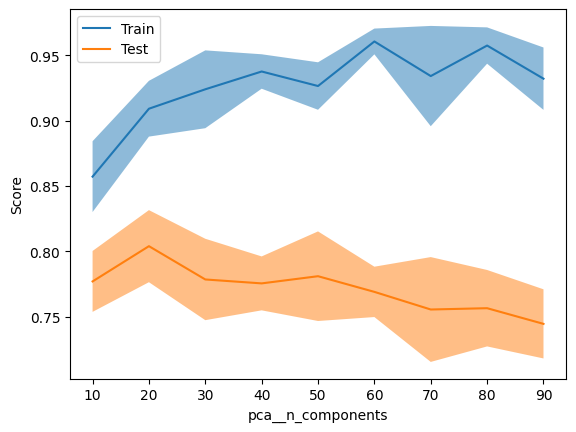

In [8]:
param_range = [i for i in range(10,100,10)]
pipeline = Pipeline([
    ('pca', PCA()), 
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', early_stopping=True))
])
train_scores, test_scores = validation_curve(
    pipeline,
    X_sub, y_sub, param_name='pca__n_components', param_range=param_range
    )

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
display = ValidationCurveDisplay(
   param_name='pca__n_components', param_range=param_range,
   train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()
plt.show()


成分の数が増えるにつれて、訓練スコアは比較的一定で高い値を保っている。\
テストスコアは初めは上昇しているが、30を境に下降している。これは、成分の数が少なすぎるとモデルがデータの本質的な特徴を捉えられないため性能が低く、成分の数が多すぎるとモデルが過学習が起きていると考えられる。

### 隠れノード数

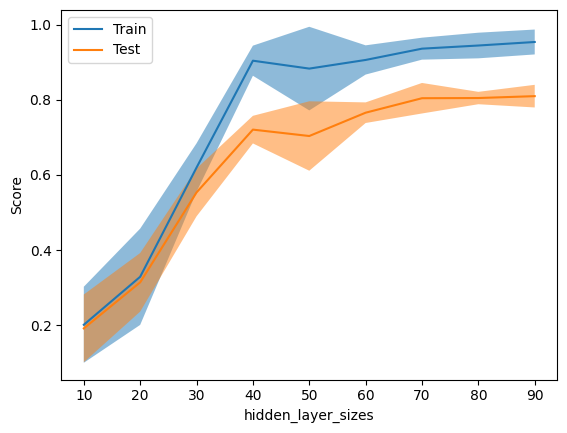

In [9]:

param_range = [i for i in range(10,100,10)]
param_range_set = [(i,) for i in range(10,100,10)]

# MLP Classifierを使用
mlp = MLPClassifier(activation='relu', solver='adam', early_stopping=True,)

# Validation Curveを計算
train_scores, test_scores = validation_curve(
    mlp,
    X_sub, y_sub, param_name='hidden_layer_sizes', param_range=param_range_set)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
display = ValidationCurveDisplay(
   param_name='hidden_layer_sizes', param_range=param_range,
   train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()
plt.show()

隠れノード数が少ない時は性能が低く、ある程度のサイズに達すると性能が改善し、その後はある程度安定している。\
50を境に不確実性が大きくなっており、テストデータに対しては過学習の傾向がある。

### 学習データ数

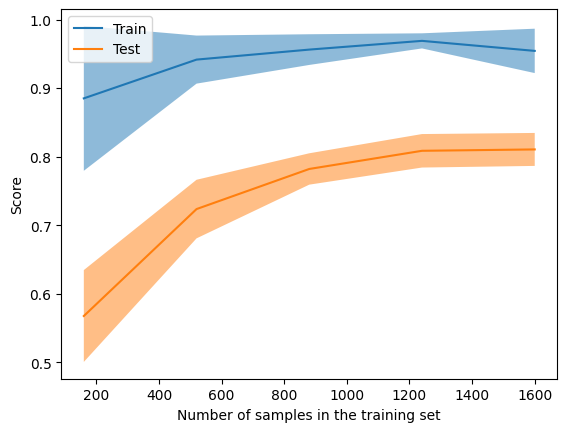

In [10]:
mlp = MLPClassifier(activation='relu', solver='adam', early_stopping=True,)
train_sizes, train_scores, test_scores = learning_curve(
    mlp, X_sub, y_sub)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

訓練データセットのサイズが増えるにつれてモデルの性能が改善される傾向にある。しかし、訓練データとテストデータのスコアには一貫して差が存在し、モデルの限界と考えられる。